In [2]:
from __future__ import print_function
import time
import numpy as np
import theano
import theano.tensor as T
import lasagne
import cPickle as pickle
from cifar10_data import load_cifar10
# import lasagne_trainer

Using gpu device 0: GeForce GTX 960M (CNMeM is disabled, CuDNN 4007)
/home/saurabh/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [4]:
# set up plots

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# get data
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("../data/cifar-10-batches-py/")
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3, 32, 32)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3, 32, 32)
Test labels shape:  (10000,)


In [5]:
X_val = X_test
y_val = y_test

In [7]:
input_var = T.tensor4('inputs')

In [8]:
def create_v1(input_var, input_shape=(3, 32, 32),
              ccp_num_filters=[64, 128], ccp_filter_size=3,
              fc_num_units=[128, 128], num_classes=10,
              **junk):
    # input layer
    network = lasagne.layers.InputLayer(shape=(None,) + input_shape,
                                        input_var=input_var)
    # conv-relu-conv-relu-pool layers
    for num_filters in ccp_num_filters:
        network = lasagne.layers.Conv2DLayer(
            network, num_filters=num_filters,
            filter_size=(ccp_filter_size, ccp_filter_size),
            pad='same',
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(gain='relu'))
        network = lasagne.layers.Conv2DLayer(
            network, num_filters=num_filters,
            filter_size=(ccp_filter_size, ccp_filter_size),
            pad='same',
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(gain='relu'))
        network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    # fc-relu
    for num_units in fc_num_units:
        network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=num_units,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(gain='relu'))
    # output layer
    network = lasagne.layers.DenseLayer(
        lasagne.layers.dropout(network, p=.5),
        num_units=num_classes,
        nonlinearity=lasagne.nonlinearities.softmax)
    return network

In [9]:
param = dict(ccp_num_filters=[64, 128], 
             ccp_filter_size=3,
             fc_num_units=[256, 256],
             num_classes=10)

In [10]:
network = create_v1(input_var, **param)

In [12]:
def gen_minibatches(X, y, batch_size, shuffle=False):
    assert len(X) == len(y), "Training data sizes don't match"
    if shuffle:
        ids = np.random.permutation(len(X))
    else:
        ids = np.arange(len(X))
    for start_idx in range(0, len(X) - batch_size + 1, batch_size):
        ii = ids[start_idx:start_idx + batch_size]
        yield X[ii], y[ii]

In [14]:
# Training params
learning_rate = .01 
learning_rate_decay=0.5
decay_after_epochs=10

momentum=0.9
momentum_decay=0.5 

regu=0.0
batch_size=128 
num_epochs=25
save_path=None


print("Compiling...")

# Training Prediction
target_var = T.ivector('target')
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()
regu_loss = lasagne.regularization.regularize_network_params(
    network, lasagne.regularization.l2)
loss = loss + regu * regu_loss
train_acc = T.mean(T.eq(T.argmax(prediction, axis=1), target_var),
                   dtype=theano.config.floatX)
learning_rate_var = theano.shared(np.float32(learning_rate))
momentum_var = theano.shared(np.float32(momentum))
params = lasagne.layers.get_all_params(network, trainable=True)

updates = lasagne.updates.nesterov_momentum(
    loss, params, learning_rate=learning_rate_var, momentum=momentum_var)

# Test prediction
test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                        target_var)
test_loss = test_loss.mean()
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

train_fn = theano.function([input_var, target_var], loss, updates=updates)
train_acc_fn = theano.function([input_var, target_var], train_acc)
val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

### All compilation done 

print("Training...")
best_val_acc = 0.0
best_model = None
loss_history = []
loss_test_history = []
train_acc_history = []
val_acc_history = []
for epoch in range(num_epochs):
    # train model for one pass
    train_err = train_batches = 0
    start_time = time.time()
    for X_batch, y_batch in gen_minibatches(X_train, y_train,
                                            batch_size, shuffle=True):
        err = train_fn(X_batch, y_batch)
        train_err += err
        train_batches += 1
        loss_history.append(err)
        
    # training accuracy
    n_acc = len(y_val)
    trval_err = trval_acc = trval_batches = 0
    for X_batch, y_batch in gen_minibatches(X_train[:n_acc], y_train[:n_acc],
                                            batch_size, shuffle=False):
        err, acc = val_fn(X_batch, y_batch)
        trval_err += err
        trval_acc += acc
        trval_batches += 1
    trval_acc /= trval_batches
    train_acc_history.append(trval_acc)
    
    # validation accuracy
    val_err = val_acc = val_batches = 0
    for X_batch, y_batch in gen_minibatches(X_val, y_val,
                                            batch_size, shuffle=False):
        err, acc = val_fn(X_batch, y_batch)
        val_err += err
        val_acc += acc
        val_batches += 1
        loss_test_history.append(err)
    val_acc /= val_batches
    val_acc_history.append(val_acc)
    
    
    print('epoch %d / %d in %.1fs: loss %f, train: %.3f, val %.3f, lr %e mom %e'
          % (epoch + 1, num_epochs, time.time() - start_time,
             train_err / train_batches, trval_acc, val_acc,
             learning_rate_var.get_value(), momentum_var.get_value()))
    
    # decay learning rate
    if (epoch + 1) % decay_after_epochs == 0:
        learning_rate_var.set_value(
            np.float32(learning_rate_var.get_value() * learning_rate_decay))
        momentum = (1.0 - (1.0 - momentum_var.get_value()) * momentum_decay) \
                   .clip(max=0.9999)
        momentum_var.set_value(np.float32(momentum))


Compiling...
Training...
epoch 1 / 25 in 59.0s: loss 1.896165, train: 0.483, val 0.473, lr 1.000000e-02 mom 9.000000e-01
epoch 2 / 25 in 58.7s: loss 1.468561, train: 0.571, val 0.561, lr 1.000000e-02 mom 9.000000e-01
epoch 3 / 25 in 61.6s: loss 1.274977, train: 0.640, val 0.631, lr 1.000000e-02 mom 9.000000e-01
epoch 4 / 25 in 76.4s: loss 1.128238, train: 0.679, val 0.672, lr 1.000000e-02 mom 9.000000e-01
epoch 5 / 25 in 60.1s: loss 1.026686, train: 0.708, val 0.692, lr 1.000000e-02 mom 9.000000e-01
epoch 6 / 25 in 68.5s: loss 0.946460, train: 0.745, val 0.721, lr 1.000000e-02 mom 9.000000e-01
epoch 7 / 25 in 58.7s: loss 0.888452, train: 0.758, val 0.729, lr 1.000000e-02 mom 9.000000e-01
epoch 8 / 25 in 64.2s: loss 0.837997, train: 0.778, val 0.735, lr 1.000000e-02 mom 9.000000e-01
epoch 9 / 25 in 76.5s: loss 0.796183, train: 0.788, val 0.743, lr 1.000000e-02 mom 9.000000e-01
epoch 10 / 25 in 58.9s: loss 0.763504, train: 0.812, val 0.761, lr 1.000000e-02 mom 9.000000e-01
epoch 11 / 25 

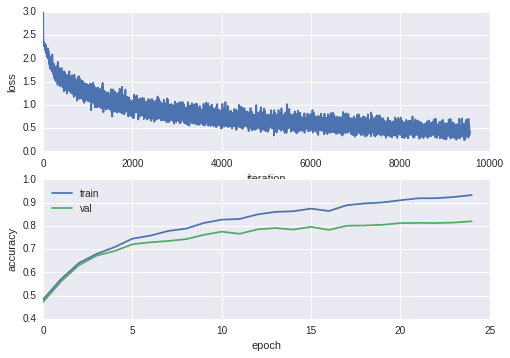

In [15]:
plt.subplot(2, 1, 1)
plt.plot(np.array(loss_history).clip(max=3))
plt.xlabel('iteration')
plt.ylabel('loss')
plt.subplot(2, 1, 2)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [ ]:
x = xrange(0,len())
sigmoid_train = loss_history
sigmoid_test = loss_test_history
# sns.plt.ylim([91,100])
sns.plt.xlabel("Epochs")
sns.plt.ylabel("Train/Test accuracy")
sns.plt.plot(x, sigmoid_train,  label = "Train accuracy" )
sns.plt.plot(x, sigmoid_test,  label = "Test accuracy" )
sns.plt.title("Sigmoid performance with 2 hidden layers (25 hidden units each)")
sns.plt.legend()

In [2]:
train_accuracy=[0.483,0.571,0.640,0.679,0.708,0.745,0.758,0.778,0.788,0.812,0.826,0.829,0.849,0.860,0.863,0.874,0.864,0.889,0.896,0.901,0.910,0.918,0.919,0.924,0.932]
test_accuracy=[0.473,0.561,0.631,0.672,0.692,0.721,0.729,0.735,0.743,0.761,0.775,0.766,0.785,0.790,0.784,0.795,0.783,0.800,0.801,0.804,0.812,0.812,0.812,0.814,0.819]

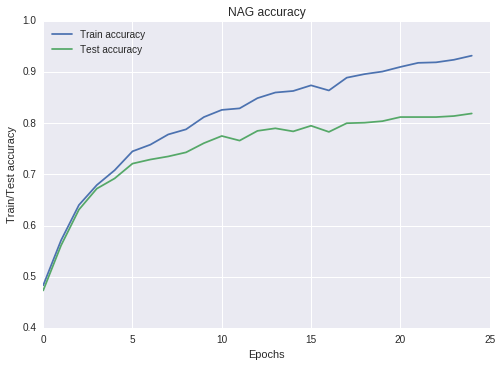

In [5]:
x = xrange(0,len(train_accuracy))
sigmoid_train = train_accuracy
sigmoid_test = test_accuracy
# sns.plt.ylim([91,100])
sns.plt.xlabel("Epochs")
sns.plt.ylabel("Train/Test accuracy")
sns.plt.plot(x, sigmoid_train,  label = "Train accuracy" )
sns.plt.plot(x, sigmoid_test,  label = "Test accuracy" )
sns.plt.title("NAG accuracy")
sns.plt.legend(loc='upper left')

In [6]:
train_loss = [1.896165,1.468561,1.274977,1.128238,1.026686,0.946460,0.888452,0.837997,0.796183,0.763504,0.726360,0.687137,0.661736,0.640836,0.617452,0.597484,0.571704,0.546876,0.526495,0.515657,0.499443,0.480146,0.461097,0.447018,0.441793]

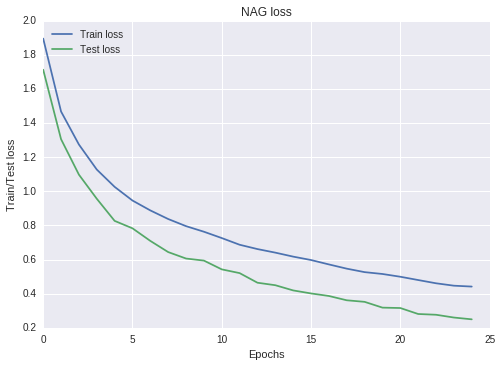

In [18]:
x = xrange(0,len(train_loss))
sigmoid_train = train_loss
sigmoid_test = test_loss
# sns.plt.ylim([91,100])
sns.plt.xlabel("Epochs")
sns.plt.ylabel("Train/Test loss")
sns.plt.plot(x, sigmoid_train,  label = "Train loss" )
sns.plt.plot(x, sigmoid_test,  label = "Test loss" )
sns.plt.title("NAG loss")
sns.plt.legend(loc='upper left')